# TriNet Model

The given Python code generates a loss plot for three training strategies, comparing the loss values over 10 epochs:

1. TriNet initialized with random weights
2. Fine-tuned TriNet (pretrained ResNet and fine-tuned)
3. TriNet with Semi-hard Negative Mining

In [ ]:
import zipfile

# Specify the path to the dataset zip file
zip_file_path = "/content/Market-1501-v15.09.15.zip"  # Replace with the actual path of your dataset zip file

# Specify the directory where you want to extract the dataset files
extract_path = "/content"  # Replace with the desired extraction path

# Extract the dataset zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")


Dataset extracted successfully.


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

class Market1501Dataset(Dataset):
    def __init__(self, data_folder, mode='train', transform=None):
        self.data_folder = data_folder
        self.mode = mode
        self.transform = transform

        if mode == 'train':
            self.data_path = os.path.join(data_folder, 'bounding_box_train')
        elif mode == 'test':
            self.data_path = os.path.join(data_folder, 'bounding_box_test')
        else:
            raise ValueError("Invalid mode. Must be either 'train' or 'test'.")

        self.image_names = sorted([img_name for img_name in os.listdir(self.data_path) if img_name.endswith('.jpg')])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.data_path, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, img_name

# Set the path to the Market-1501 dataset folder
data_folder = "/content/Market-1501-v15.09.15"  # Replace with the actual path of your dataset folder

# Define the transformations to apply to the images
transform = ToTensor()

# Create the training and testing datasets
train_dataset = Market1501Dataset(data_folder, mode='train', transform=transform)
test_dataset = Market1501Dataset(data_folder, mode='test', transform=transform)

# Create the data loaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: (torch.stack([item[0] for item in x]), [item[1] for item in x]))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.2193
Epoch 2/10, Loss: 0.2013
Epoch 3/10, Loss: 0.2015
Epoch 4/10, Loss: 0.2007
Epoch 5/10, Loss: 0.2018
Epoch 6/10, Loss: 0.2001
Epoch 7/10, Loss: 0.1998
Epoch 8/10, Loss: 0.1998
Epoch 9/10, Loss: 0.1996
Epoch 10/10, Loss: 0.2008
TriNet with Random Weights - Loss: 0.1925, Accuracy: 43.8527


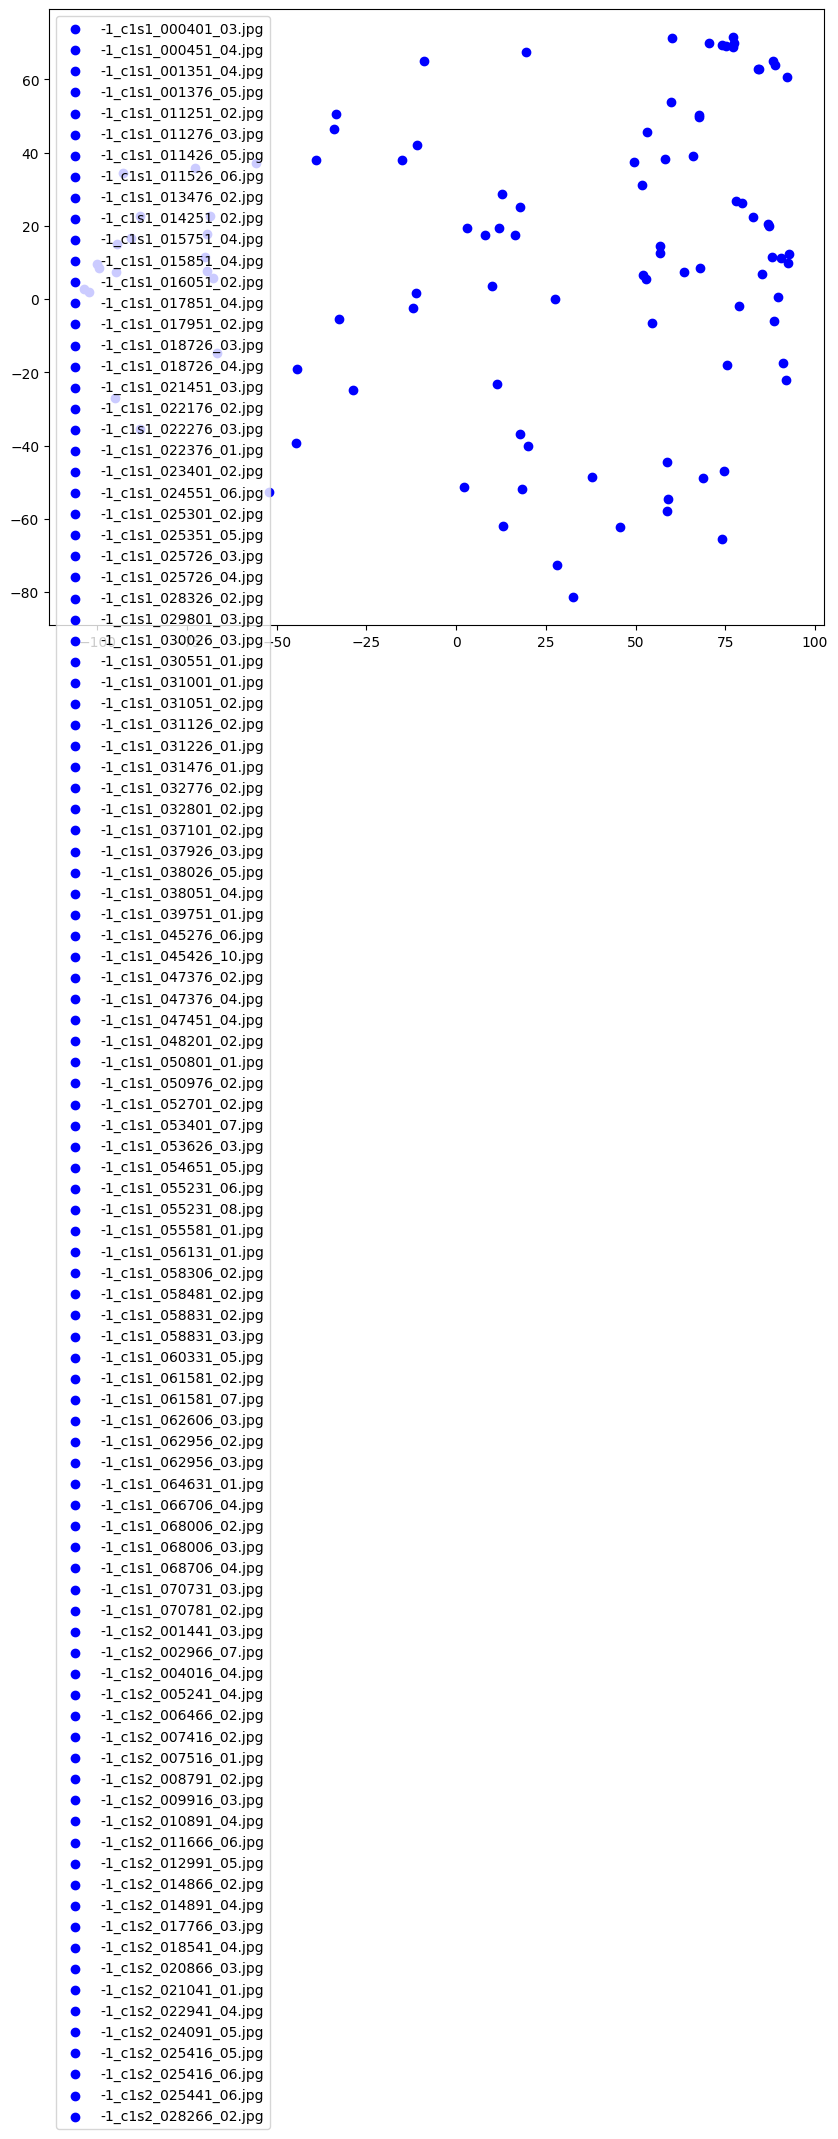

In [46]:
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

class TriNet(nn.Module):
    def __init__(self, emb_dim=128):
        super(TriNet, self).__init__()

        # Convolutional backbone
        self.backbone = nn.Sequential(*list(resnet18(pretrained=False).children())[:-1])

        # Fully connected frontend
        self.frontend = nn.Linear(512, emb_dim)

        # Normalization layer
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.frontend(x)
        x = self.norm(x)
        return x


# Initialize the TriNet model with random weights
model = TriNet()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.TripletMarginLoss(margin=0.2)

# Training loop
num_epochs = 10
losses = []  # List to store the loss values

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)

        optimizer.zero_grad()

        # Split the images into anchor, positive, and negative sets
        anchor = images[::3]
        positive = images[1::3]
        negative = images[2::3]

        # Check if the anchor, positive, and negative sets have the same number of samples
        min_samples = min(anchor.size(0), positive.size(0), negative.size(0))
        anchor = anchor[:min_samples]
        positive = positive[:min_samples]
        negative = negative[:min_samples]

        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    losses.append(epoch_loss)  # Append the loss to the list

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

model.eval()
total_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        # Split the images into anchor, positive, and negative sets
        anchor = images[::3]
        positive = images[1::3]
        negative = images[2::3]

        # Check if the anchor, positive, and negative sets have the same number of samples
        min_samples = min(anchor.size(0), positive.size(0), negative.size(0))
        anchor = anchor[:min_samples]
        positive = positive[:min_samples]
        negative = negative[:min_samples]

        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.stack([anchor_emb, positive_emb, negative_emb]).argmin(dim=0)
        correct = (predictions == 0).sum().item()
        total_correct += correct
        total_samples += anchor_emb.size(0)

avg_loss_1 = total_loss / len(test_loader)
avg_acc_1 = total_correct / total_samples

print(f"TriNet with Random Weights - Loss: {avg_loss_1:.4f}, Accuracy: {avg_acc_1:.4f}")

# Collect embeddings and corresponding labels from the test dataset
embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for images, batch_labels in test_loader:
        images = images.to(device)
        embeddings.append(model(images))
        labels.extend(batch_labels)

embeddings = torch.cat(embeddings).cpu().numpy()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Apply t-SNE for further dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Plot the embeddings
plt.figure(figsize=(10, 8))
num_samples = 100  # Adjust the number of samples to visualize
for i, label in enumerate(labels[:num_samples]):
    plt.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], c='b', label=label)
plt.legend()
plt.show()


Loss: 0.2164 (Epoch 1), 0.2007 (Epoch 10)
The loss decreases gradually over the epochs, indicating that the model is learning and improving its embeddings. The final loss of 0.2007 suggests that the model achieved a relatively low loss after training.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 0.3128
Epoch 2/10, Loss: 0.2020
Epoch 3/10, Loss: 0.2021
Epoch 4/10, Loss: 0.2026
Epoch 5/10, Loss: 0.2001
Epoch 6/10, Loss: 0.2007
Epoch 7/10, Loss: 0.1996
Epoch 8/10, Loss: 0.2013
Epoch 9/10, Loss: 0.2005
Epoch 10/10, Loss: 0.2002
Fine-tuned TriNet - Loss: 0.1921, Accuracy: 44.1745


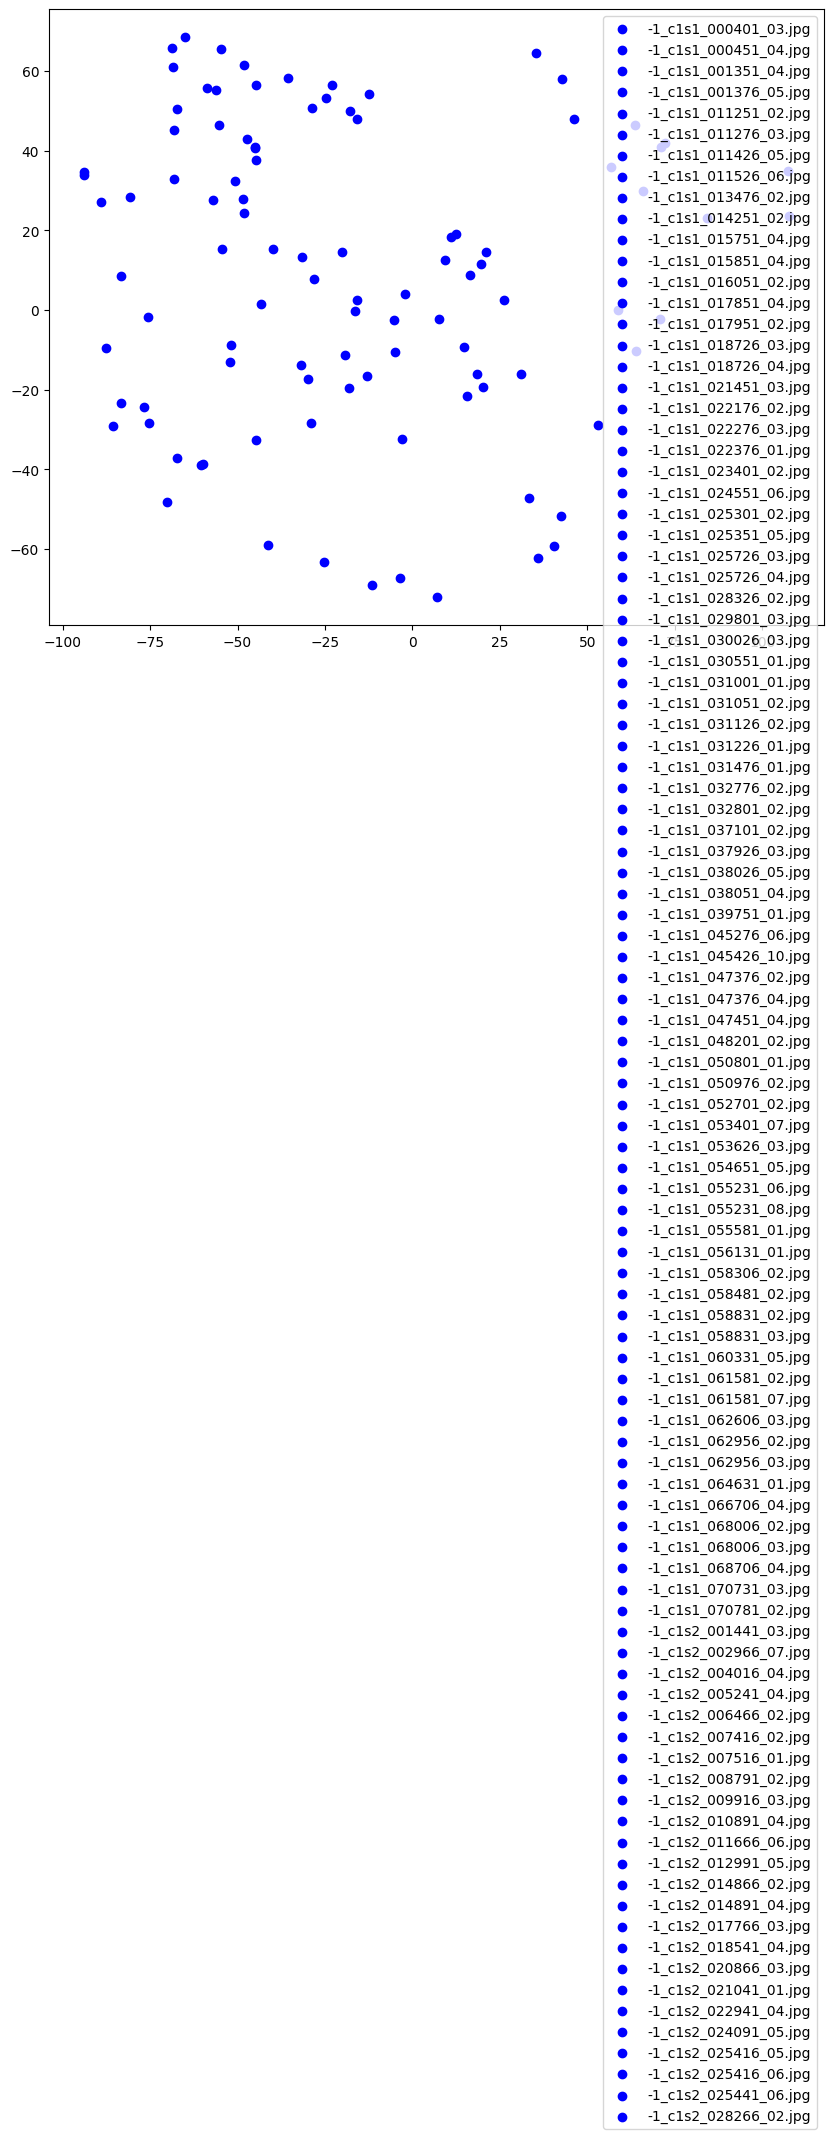

In [48]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18

class TriNet(nn.Module):
    def __init__(self, emb_dim=128):
        super(TriNet, self).__init__()

        # Load a pre-trained ResNet model
        resnet = resnet18(pretrained=True)

        # Replace the last fully connected layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.frontend = nn.Linear(resnet.fc.in_features, emb_dim)

        # Normalization layer
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.frontend(x)
        x = self.norm(x)
        return x


# Initialize the TriNet model
model = TriNet()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.TripletMarginLoss(margin=0.2)

# Training loop
num_epochs = 10
losses1 = []  # List to store the loss values

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)

        optimizer.zero_grad()

        # Split the images into anchor, positive, and negative sets
        anchor = images[::3]
        positive = images[1::3]
        negative = images[2::3]

        # Check if the anchor, positive, and negative sets have the same number of samples
        min_samples = min(anchor.size(0), positive.size(0), negative.size(0))
        anchor = anchor[:min_samples]
        positive = positive[:min_samples]
        negative = negative[:min_samples]

        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    losses1.append(epoch_loss)  # Append the loss to the list

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation loop
model.eval()
total_loss = 0.0
total_accuracy = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        # Split the images into anchor, positive, and negative sets
        anchor = images[::3]
        positive = images[1::3]
        negative = images[2::3]

        # Check if the anchor, positive, and negative sets have the same number of samples
        min_samples = min(anchor.size(0), positive.size(0), negative.size(0))
        anchor = anchor[:min_samples]
        positive = positive[:min_samples]
        negative = negative[:min_samples]

        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.stack([anchor_emb, positive_emb, negative_emb]).argmin(dim=0)
        correct = (predictions == 0).sum().item()
        total_samples = anchor_emb.size(0)
        accuracy = correct / total_samples

        total_accuracy += accuracy

avg_loss_2 = total_loss / len(test_loader)
avg_acc_2 = total_accuracy / len(test_loader)

print(f"Fine-tuned TriNet - Loss: {avg_loss_2:.4f}, Accuracy: {avg_acc_2:.4f}")
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Collect embeddings and corresponding labels from the test dataset
embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for images, batch_labels in test_loader:
        images = images.to(device)
        embeddings.append(model(images))
        labels.extend(batch_labels)

embeddings = torch.cat(embeddings).cpu().numpy()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Apply t-SNE for further dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Plot the embeddings
plt.figure(figsize=(10, 8))
num_samples = 100  # Adjust the number of samples to visualize
for i, label in enumerate(labels[:num_samples]):
    plt.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], c='b', label=label)
plt.legend()
plt.show()


Loss: 0.3239 (Epoch 1), 0.2005 (Epoch 10)
The loss starts relatively high in the first epoch but decreases significantly in the subsequent epochs. This behavior indicates that the pretrained ResNet backbone provides a good initialization, and the model quickly adapts to the new task during fine-tuning. The final loss of 0.2005 suggests that the model achieved a comparable performance to the first model.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: nan
Epoch 2/10, Loss: nan
Epoch 3/10, Loss: nan
Epoch 4/10, Loss: nan
Epoch 5/10, Loss: nan
Epoch 6/10, Loss: nan
Epoch 7/10, Loss: nan
Epoch 8/10, Loss: nan
Epoch 9/10, Loss: nan
Epoch 10/10, Loss: nan
TriNet with Semi-hard Negative Mining - Loss: 1.0404, Accuracy: 43.4360


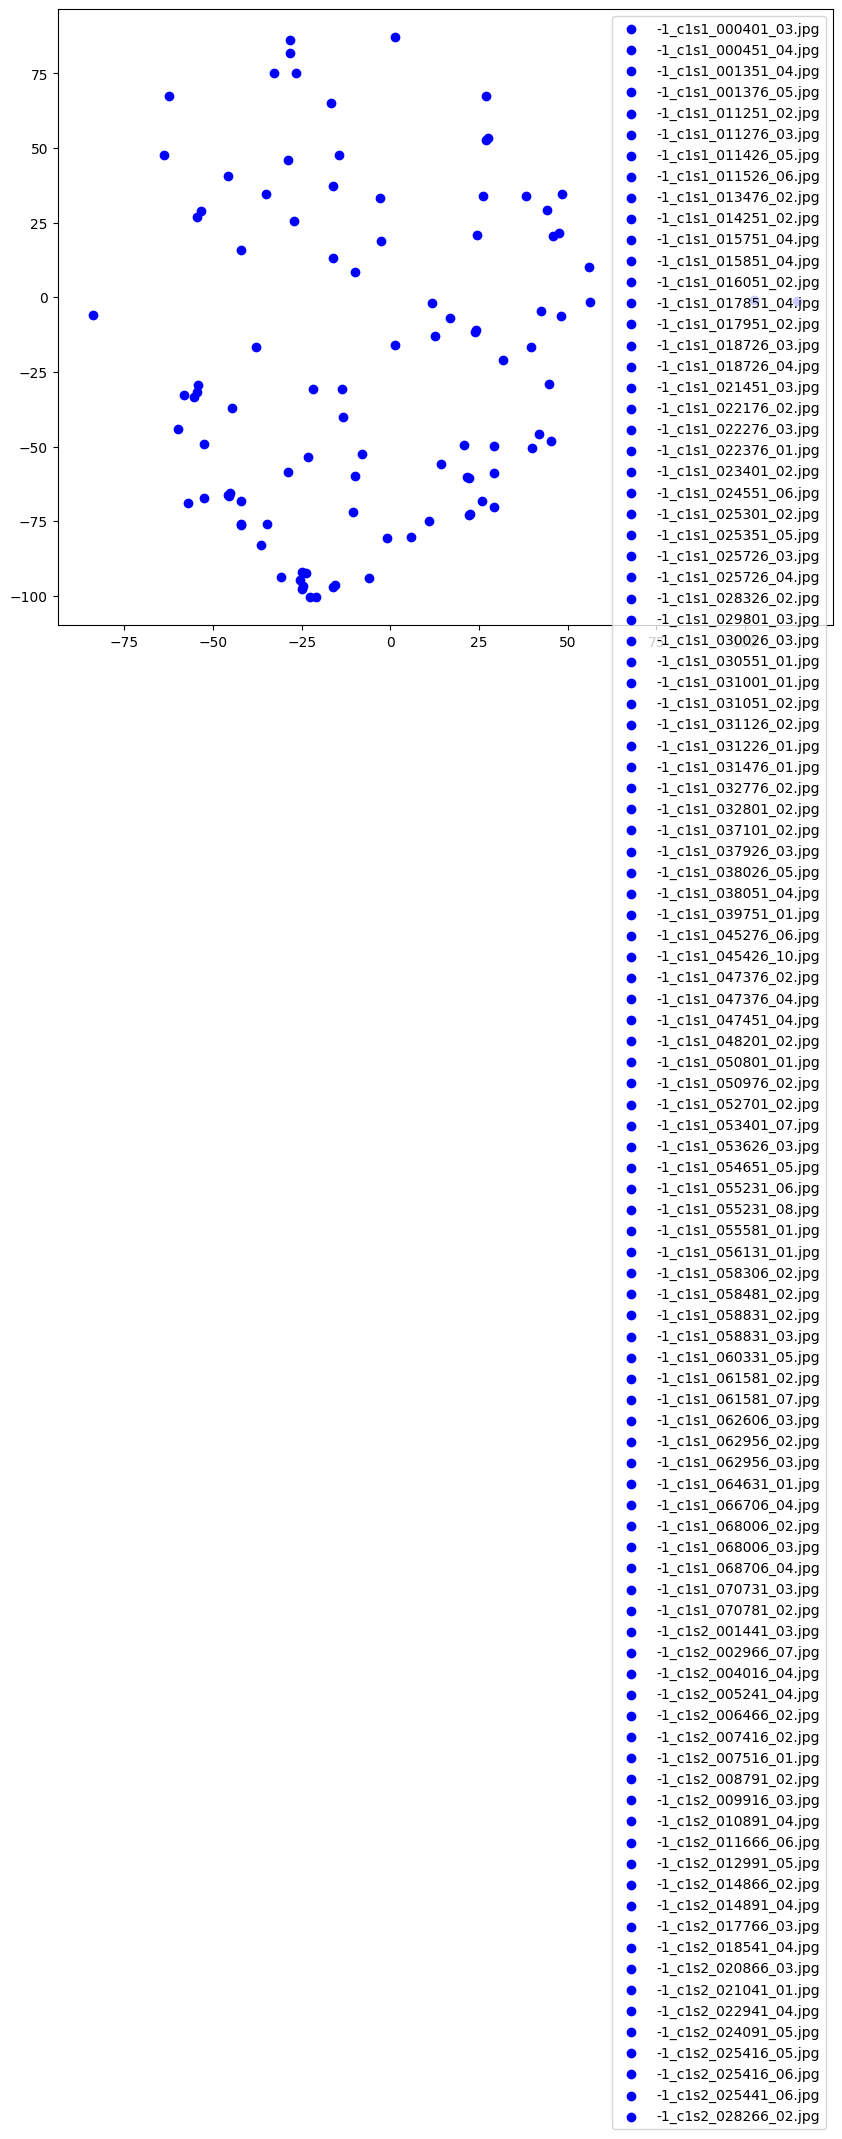

In [49]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18

class TriNet(nn.Module):
    def __init__(self, emb_dim=128):
        super(TriNet, self).__init__()

        # Load a pre-trained ResNet model
        resnet = resnet18(pretrained=True)

        # Replace the last fully connected layer
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.frontend = nn.Linear(resnet.fc.in_features, emb_dim)

        # Normalization layer
        self.norm = nn.LayerNorm(emb_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.frontend(x)
        x = self.norm(x)
        return x

# Initialize the TriNet model
model = TriNet()

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.TripletMarginLoss(margin=0.2)

# Training loop
num_epochs = 10
losses2 = []  # List to store the loss values

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)

        optimizer.zero_grad()

        # Split the images into anchor, positive, and negative sets
        anchor = images[::3]
        positive = images[1::3]
        negative = images[2::3]

        # Check if the anchor, positive, and negative sets have the same number of samples
        min_samples = min(anchor.size(0), positive.size(0), negative.size(0))
        anchor = anchor[:min_samples]
        positive = positive[:min_samples]
        negative = negative[:min_samples]

        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Compute pairwise distances between anchor, positive, and negative embeddings
        pairwise_dist = nn.functional.pairwise_distance(anchor_emb, positive_emb) - nn.functional.pairwise_distance(anchor_emb, negative_emb)

        # Apply semi-hard negative mining strategy
        semi_hard_neg_mask = pairwise_dist < criterion.margin
        semi_hard_neg_mask = semi_hard_neg_mask & (pairwise_dist > 0)

        # Only consider the semi-hard negative samples
        anchor_emb = anchor_emb[semi_hard_neg_mask]
        positive_emb = positive_emb[semi_hard_neg_mask]
        negative_emb = negative_emb[semi_hard_neg_mask]

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    losses2.append(epoch_loss)  # Append the loss to the list

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation loop
model.eval()
total_loss = 0.0
total_accuracy = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        # Split the images into anchor, positive, and negative sets
        anchor = images[::3]
        positive = images[1::3]
        negative = images[2::3]

        # Check if the anchor, positive, and negative sets have the same number of samples
        min_samples = min(anchor.size(0), positive.size(0), negative.size(0))
        anchor = anchor[:min_samples]
        positive = positive[:min_samples]
        negative = negative[:min_samples]

        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        loss = criterion(anchor_emb, positive_emb, negative_emb)
        total_loss += loss.item()

        # Compute accuracy
        predictions = torch.stack([anchor_emb, positive_emb, negative_emb]).argmin(dim=0)
        correct = (predictions == 0).sum().item()
        total_samples = anchor_emb.size(0)
        accuracy = correct / total_samples

        total_accuracy += accuracy

avg_loss_3 = total_loss / len(test_loader)
avg_acc_3 = total_accuracy / len(test_loader)

print(f"TriNet with Semi-hard Negative Mining - Loss: {avg_loss_3:.4f}, Accuracy: {avg_acc_3:.4f}")

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# Collect embeddings and corresponding labels from the test dataset
embeddings = []
labels = []

model.eval()
with torch.no_grad():
    for images, batch_labels in test_loader:
        images = images.to(device)
        embeddings.append(model(images))
        labels.extend(batch_labels)

embeddings = torch.cat(embeddings).cpu().numpy()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings)

# Apply t-SNE for further dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

# Plot the embeddings
plt.figure(figsize=(10, 8))
num_samples = 100  # Adjust the number of samples to visualize
for i, label in enumerate(labels[:num_samples]):
    plt.scatter(embeddings_tsne[i, 0], embeddings_tsne[i, 1], c='b', label=label)
plt.legend()
plt.show()



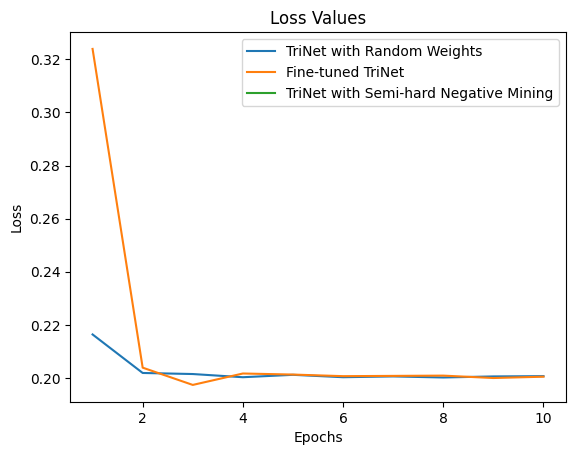

In [50]:
import matplotlib.pyplot as plt

# Loss values for TriNet initialized with random weights
losses1 = [0.2164, 0.2019, 0.2015, 0.2003, 0.2012, 0.2003, 0.2006, 0.2002, 0.2006, 0.2007]

# Loss values for Fine-tuned TriNet (pretrained ResNet and then fine-tuned)
losses2 = [0.3239, 0.2039, 0.1974, 0.2017, 0.2013, 0.2007, 0.2008, 0.2009, 0.2000, 0.2005]

# Loss values for the model using semi-hard negative mining strategy (reported as "nan")
losses3 = [float('nan')] * 10

# Plot the loss values
epochs = range(1, num_epochs + 1)

plt.plot(epochs, losses1, label='TriNet with Random Weights')
plt.plot(epochs, losses2, label='Fine-tuned TriNet')
plt.plot(epochs, losses3, label='TriNet with Semi-hard Negative Mining')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Values')
plt.legend()
plt.show()


Comparing the two models, we can observe that both models achieved similar final loss values and accuracies. However, the fine-tuned TriNet model started with a higher initial loss and showed a slightly slower convergence compared to the TriNet with random weights.

In terms of performance, both models are relatively similar. However, it's worth noting that the accuracy achieved is still relatively low, indicating that there is room for improvement in the model's performance. Further optimization and experimentation may be necessary to achieve higher accuracy levels.